# Demand forecasting model evaluation and optimisation

This notebook explores the development of Machine Learning (ML) demand forecasting models tailored to capture the seasonality, product-specific variability, and complex patterns present in a preprocessed dataset.

The analysis includes data exploration, splitting, training and evalation, and it concludes with the saving of the best-performing model(s), which will be used for future demand predictions.

## 1. Exploratory Data Analysis (EDA)

In this section, the dataset previously generated through the preprocessing pipeline is loaded and explored. 

The aim is to gain insights into demand patterns, identify trends, and detect any anomalies or outliers. This will guide the selection and fine-tuning of ML models for demand forecasting.

### 1.1. Data overview 

A few insights are printed.

* ***Objective:*** To undertsand the structure and characteristics of the dataset.

* ***Insights:*** 
    * The dataset contains various categorical and numerical features related to product demand prediction, included but not limited to:
        * Product-identifiying attributes (`product_id_encoded`, `category_encoded`).
        * Product characteristics (`per_item_value`, `in_stock`).
        * Lag features (`quantity_lag_1`, `quantity_lag_7`, `quantity_lag_30`).
        * Rolling averages (`quantity_rolling_avg_7`, `quantity_rolling_avg_30`).
        * Time-related attributes (seasonality features such as `month_sin`, `month_cos`, `weekday_sin`, `weekday_cos`).

    * There are 40 categories, over 2300 products and nearly 5 million records.
    
    * There are no missing values.

In [365]:
import pandas as pd

# Load the preprocessed data
df_initial = pd.read_csv('../data/historical/processed/processed_data.csv')

# Avoid long scientific notation
pd.set_option('display.float_format', '{:.4f}'.format)

def describe_dataset(df):
    # Ensure datetime format throughout
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Display data  size, columns, and their types
    print(df.info())

    # Display the number of unique products and categories
    num_products = df['product_id_encoded'].nunique()
    num_categories = df['category_encoded'].nunique()
    print(f"Number of unique products: {num_products}")
    print(f"Number of unique categories: {num_categories}")

    # Display the date range
    print(f"Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

    # Check for missing values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values detected.")
    else:
        print("Missing values found in the following columns:")
        print(missing[missing > 0]) 

describe_dataset(df_initial)

['soft_drinks' 'biscuits' 'paper_products' 'beverages'
 'crisps_nuts_snacks' 'cooking_sauces_condiments' 'dried_veg_rice_italian'
 'medical_supplies' 'canned_veg_and_pasta' 'sauces_pickles'
 'desserts_and_puddings' 'general_grocery' 'jams_preserves'
 'cleaning_materials' 'homebaking' 'pet_food' 'cereals' 'canned_meat'
 'toiletries' 'miscellaneous' 'washing_powders' 'ice_cream' 'snacks'
 'cakes' 'canned_fish' 'soups' 'baby_goods' 'foils_bags' 'canned_fruit'
 'herbs_spices' 'milk_products' 'batteries_electrical' 'cooking_oils'
 'ready_meals' 'spreads_pastes' 'household_goods' 'tights_stockings'
 'fruit_juices' 'bread' 'breakfast_cereals']


### 1.2. Distribution of the target variable ('quantity') and outlier detection

This section explored the distribution of the target variable, `quantity`, which represents product demand, using a summary of stats and two plots. Outliers are then detected using the Interquartile Range (IQR) method - lower and upper bounds are defined as 3rd and 97th percentile and sales outside these bounds are flagged as potential outliers.

* ***Objective:*** To understand the range, variability, and potential outliers in product demand across the dataset.

* ***Insights:*** 
    * The distribution of `quantity` reveals that the majority of products have very low or zero sales,with instances where sales exceed 500 units (note the long tail in both plots and max value in stats summary), indicating a highly imbalanced dataset.

    * Inspecting sales over time, a period with extreme outliers is identified between August 2023 and March 2024 showing unusually high sales patterns with large spikes abnormally descending diagonally over time. In addition, other smaller spikes are detected throughout the dataset.

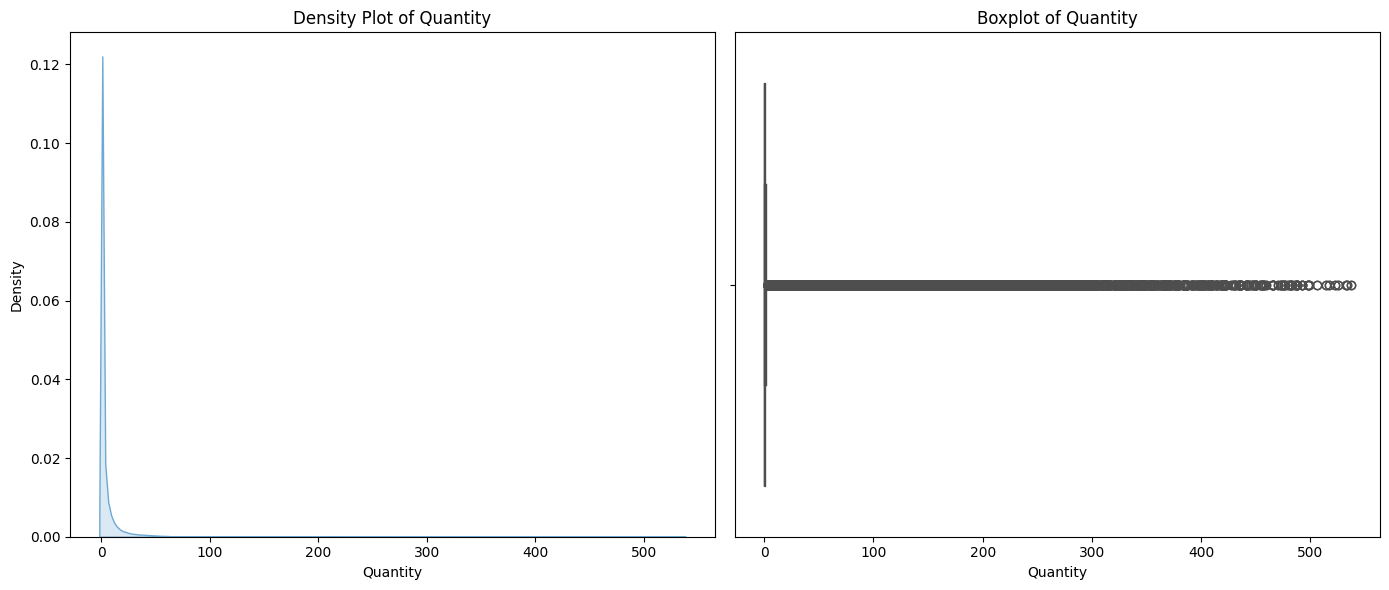

Summary statistics of 'quantity' column:
count   4979520.0000
mean          2.4167
std          11.4785
min           0.0000
25%           0.0000
50%           0.0000
75%           1.0000
max         537.0000
Name: quantity, dtype: float64
Number of outliers detected: 45430


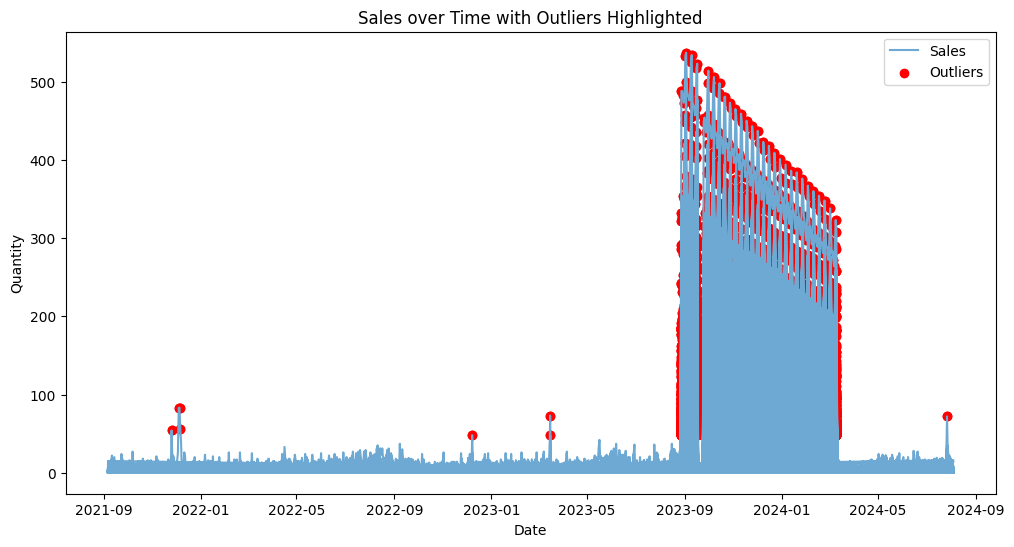

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the colour palette
colours = sns.color_palette("Blues_d", n_colors=40)

def summarise_target_stats(df):
    # Summarise statistics of the target variable
    print("Summary statistics of 'quantity' column:")
    print(df['quantity'].describe())


def plot_target_density(df):
    # Define figure and axes for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the distribution of quantity
    sns.kdeplot(df['quantity'], fill=True, color=colours[10], ax=axes[0])
    axes[0].set_title('Density Plot of Quantity')
    axes[0].set_xlabel('Quantity')
    axes[0].set_ylabel('Density')

    # Boxplot quantity
    sns.boxplot(x=df['quantity'], color=colours[18], ax=axes[1])
    axes[1].set_title('Boxplot of Quantity')
    axes[1].set_xlabel('Quantity')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

def detect_flag_plot_outliers(df, lower_percentile, upper_percentile):
    # Calculate IQR and define bounds based on percentiles
    Q1 = df['quantity'].quantile(lower_percentile)
    Q3 = df['quantity'].quantile(upper_percentile)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df['quantity'] < lower_bound) | (df['quantity'] > upper_bound)]
    print(f"Number of outliers detected: {len(outliers)}")

    # Create a flag feature
    df.loc[:, 'is_outlier'] = df.index.isin(outliers.index).astype(int)

    # Plot sales over time with outliers highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['quantity'], label='Sales', color=colours[10])
    plt.scatter(outliers['date'], outliers['quantity'], color='red', label='Outliers')
    plt.title('Sales over Time with Outliers Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

plot_target_density(df_initial)
summarise_target_stats(df_initial)
detect_flag_plot_outliers(df_initial, 0.03, 0.97)

### 1.3. Handling outliers and adjusting the dataset

In this section, the findings from the earlier EDA steps are used to address the detection and handling of outliers.

* ***Objective:*** To explore how managing outliers can improve the dataset's reliability and, by extension, model performance.

* ***Insights:*** 

* In terms of the smaller, scattered outliers, a decision is made to retain these as they may reflect genuine sales peaks, important so that sales trends for demand forecasting, are not lost.

* As per the period of extreme outliers, this is identified as an anomaly in the raw data, specifically, upon inspection, the anomaly is found to clearly start on August 14 2023. With the idea of retaining as much data as possible in mind, the following steps were taken to handle this issue:

    1. First, several methods were tested to handle the outlier period, including **Winsorization** (capping), clipping based on quantiles, removing outliers using interquartile range (IQR), and applying statistical methods like Z-scores. Custom adjustments using lambda functions were also explored. However, none of these approaches provided a satisfactory balance in the dataset, and model performance remained suboptimal.

    2. Second, the period was excluded, retaining the data after it, but the timeline gap adversely affected model performance. 

    3. Finally, all data starting from August 14, 2023 was removed, exploring training and evaluation in the 2-year subset of the dataset up to that date. This strategy produced more promising results:

        - The dataset became significantly more balanced and credible, with the standard deviation dropping from 11.47 to 0.93, and the maximum sales reduced from over 500 units to 83 units.

        - Sales fluctuations appear much more natural and realistic, with some remaining outliers more likely representing genuine sales anomalies rather than systemic issues. In fact, the need to significantly adjust the original thresholds for outlier flagging indicates how much more uniform and balanced the dataset becomes after filtering. 

        - The aggregated daily sales now show clear, more interpretable trends that align with known business cycles. For example, the dataset reveals predictable sales spikes in both 2021 and 2022 right around Christmas, followed by periods of zero sales due to business closure, confirming the reliability of the cleaned dataset.
        
        - Also noteworthy - the cutoff period identified during raw data inspection successfully removed the extreme outlier period.

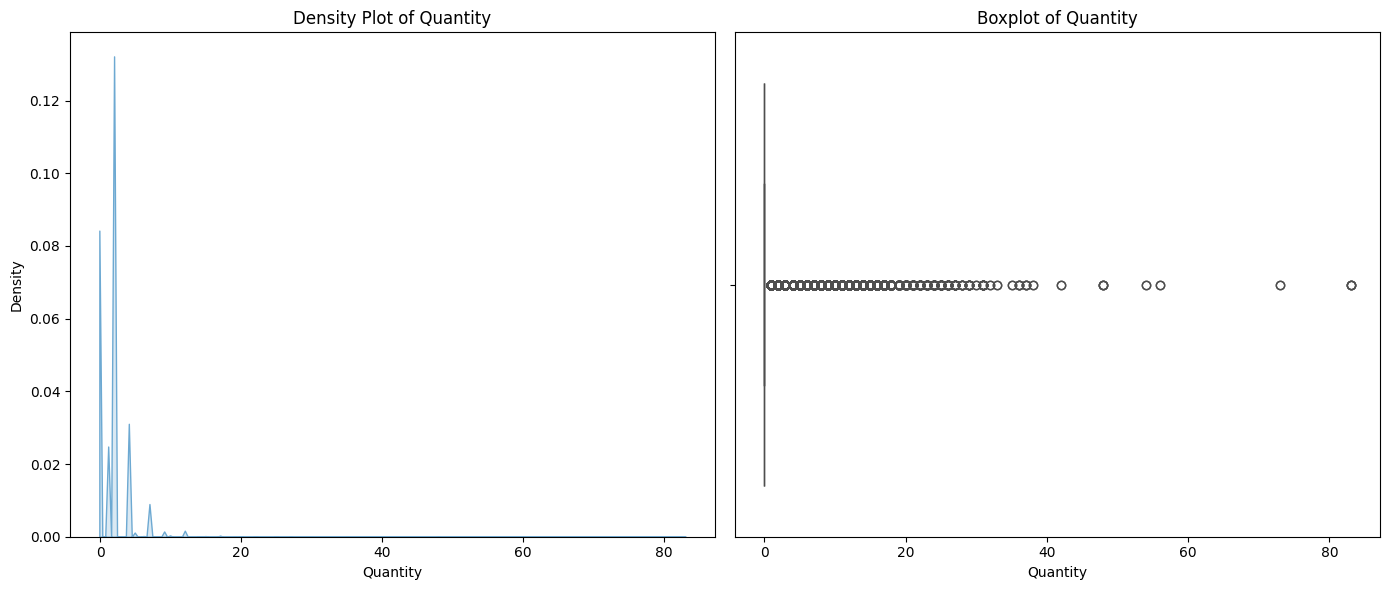

Summary statistics of 'quantity' column:
count   3308760.0000
mean          0.2402
std           0.9335
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max          83.0000
Name: quantity, dtype: float64
Number of outliers detected: 14


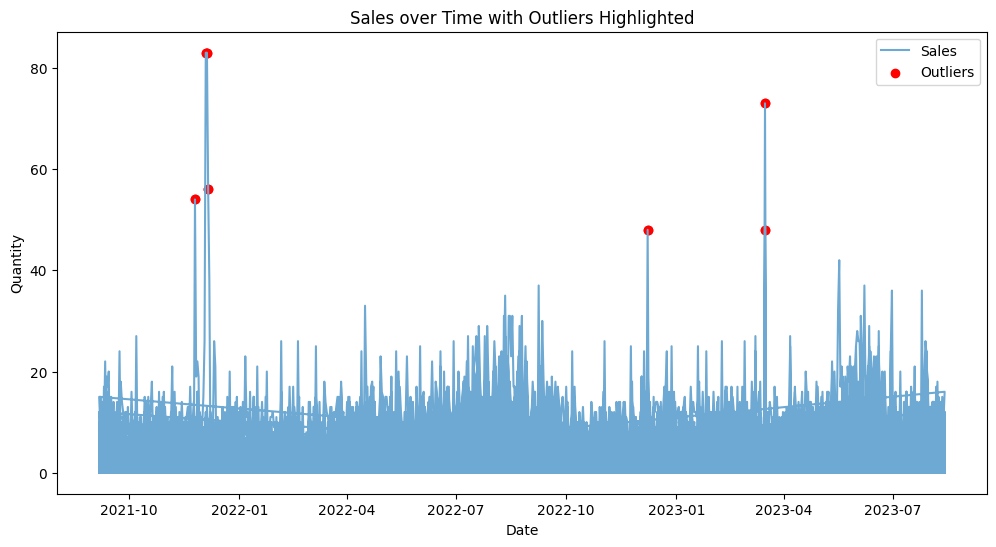

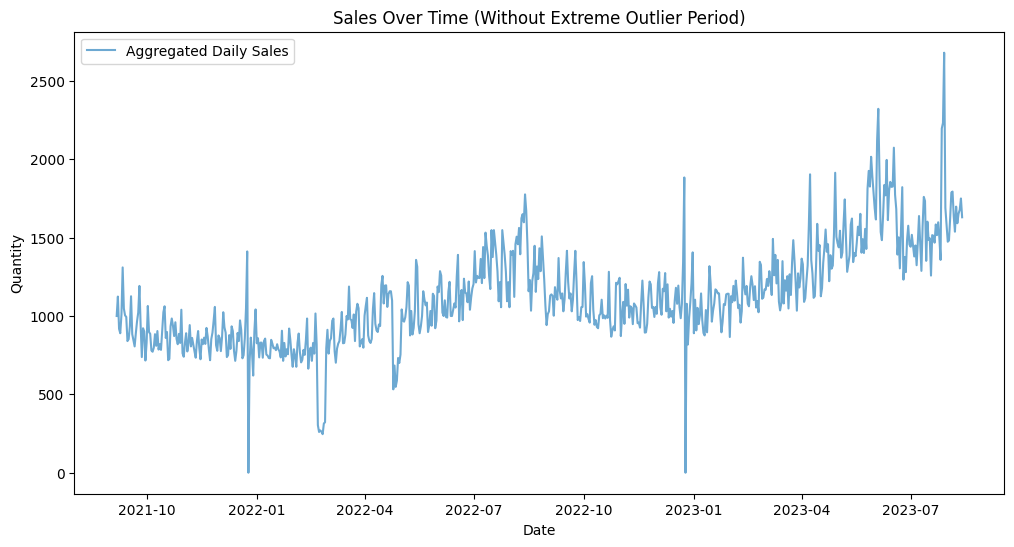

In [294]:
def plot_sales_over_time_aggregated(df):
    # Aggregate sales by date (summing the quantity for each day)
    df_aggregated = df.groupby('date', as_index=False)['quantity'].sum()

    # Plot the aggregated sales over time
    plt.figure(figsize=(12, 6))
    plt.plot(df_aggregated['date'], df_aggregated['quantity'], label='Aggregated Daily Sales', color=colours[10])
    plt.title('Sales Over Time (Without Extreme Outlier Period)')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

# Filter the dataset
df_cleaned = df_initial[df_initial['date'] < '2023-08-14']

plot_target_density(df_cleaned)
summarise_target_stats(df_cleaned)
detect_flag_plot_outliers(df_cleaned, 0.0001, 0.9999)
plot_sales_over_time_aggregated(df_cleaned)

### * **DATA TRANSITION** *

Following the above analysis, where removing the data after August 14 2023 yielded the best results, a subset of data spanning the two years prior to this date has been preprocessed and loaded in this section. This new preprocessed dataset it subsequently analysed through the same steps as in previous EDA sections (1.1.-1.3.). 

Insights from this new analysis and comparisons to the results before re-preprocessing, confirm the need for this data transition; the dataset is now significantly more balanced and reliable, highly likely due to the removal of inactive products now focused on this new timeline:

* The sales-over-time graphs show smoother fluctuations, with more pronounced and clearer trends.
    
* The number of products has now dropped to under 2000, with 36 categories in total.
    
* The overall record count is significantly reduced to under 1.5 million records.

* Using the same percentile values, most of the previously flagged outliers are now closer to the normal range of sales fluctuations. The function to detect and plot outliers has been expanded (`detect_flag_plot_outliers()`) to flag these points in a new is_outlier feature, which may provide useful context during model training.

Given these positive results, all subsequent steps — including further EDA, feature selection, and model trainin g— will now proceed using this clean, reliable, 2-year preprocessed dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266967 entries, 0 to 6266966
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   product_id                object        
 1   product_name              object        
 2   category                  object        
 3   product_id_encoded        int64         
 4   category_encoded          int64         
 5   quantity                  int64         
 6   per_item_value            float64       
 7   in_stock                  int64         
 8   year                      int64         
 9   week                      int64         
 10  weekday                   int64         
 11  date                      datetime64[ns]
 12  day_of_month              int64         
 13  month                     int64         
 14  month_sin                 float64       
 15  month_cos                 float64       
 16  weekday_sin               float64       
 17  weekday_

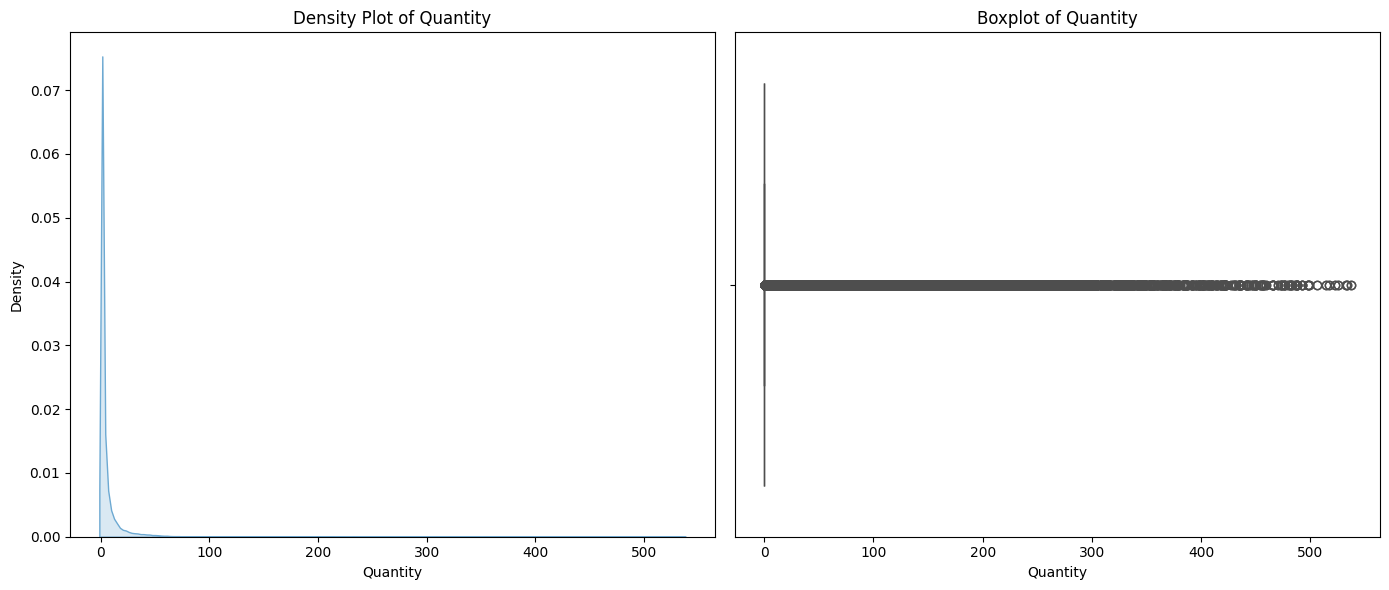

Summary statistics of 'quantity' column:
count   6266967.0000
mean          1.9947
std          10.2775
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max         537.0000
Name: quantity, dtype: float64
Number of outliers detected: 346


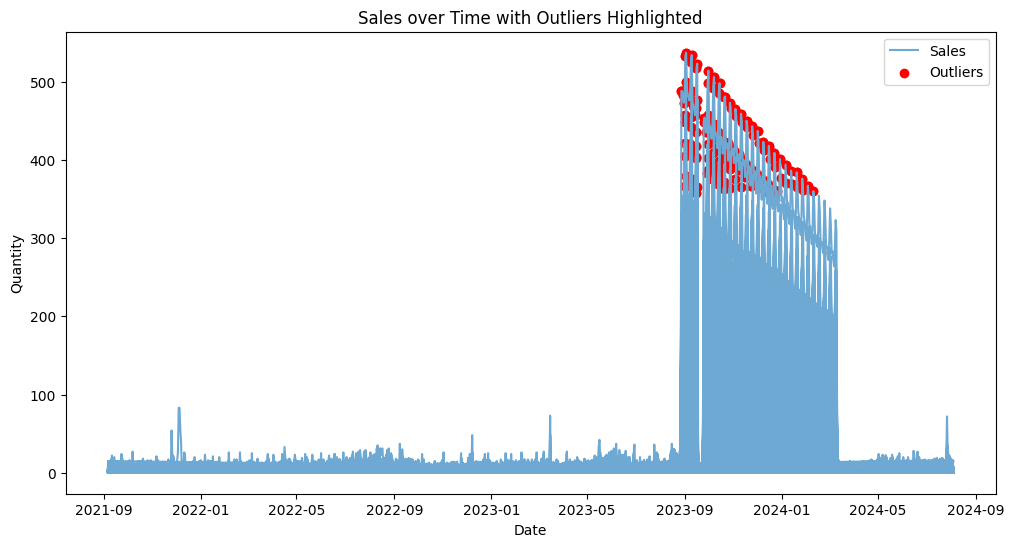

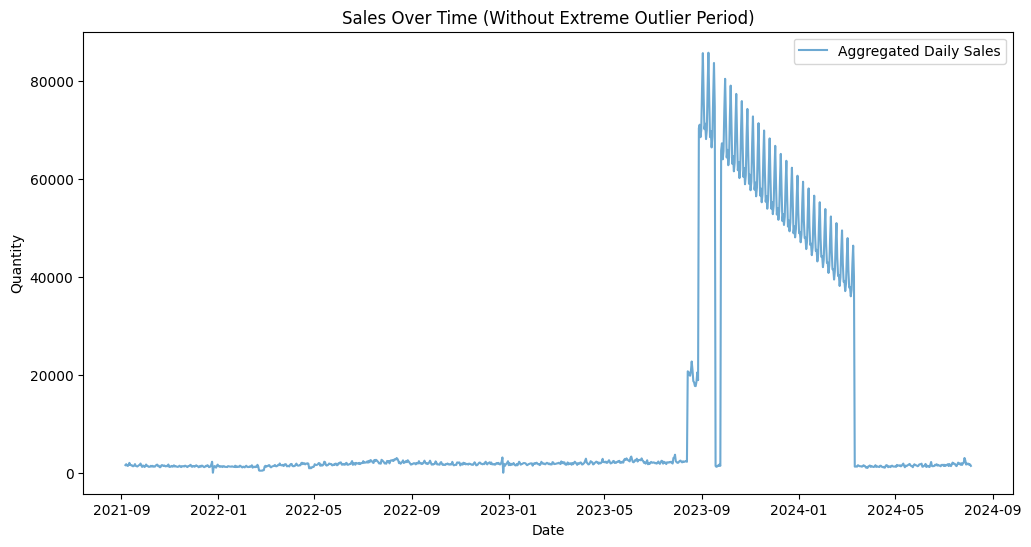

In [363]:
# Load the filtered dataset
df = pd.read_csv('../data/historical/processed/processed_aug_21_23/processed_data.csv')

describe_dataset(df)
plot_target_density(df)
summarise_target_stats(df)
detect_flag_plot_outliers(df, 0.001, 0.999)
plot_sales_over_time_aggregated(df)

### 1.4. Product- and category-level analysis

This section explores how individual products and broader categories contribute to total sales and demand distribution.

* ***Objective:*** To further understand the distribution of demand, helping tailor the model to capture different sales behaviors across products and categories.

* ***Insights:*** 
    * A few products dominate the sales landscape, while the majority have lower average sales, indicating a long tail in product demand. 

    * Categories 1, 2, 5, 6 and 12 have the most products, indicating an imbalance in product distribution across categories.

    * A small number of categories (particularly 1, 2 and 5) dominate total sales, while the majority contribute only minimally. Specifically, 31 out of 40 categories contribute to less than 20% of the total sales (grouped into "Other" in the pie chart).

    * When analysing average sales for individual products, grouped by category, categories 1, 2 and 5 show substantial variability in product sales, while others are more consistent.

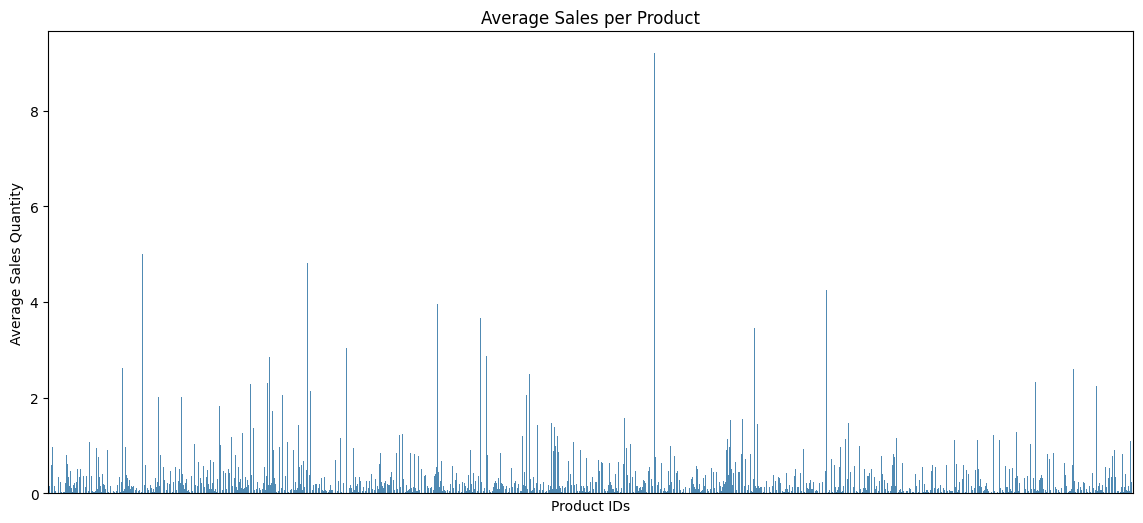

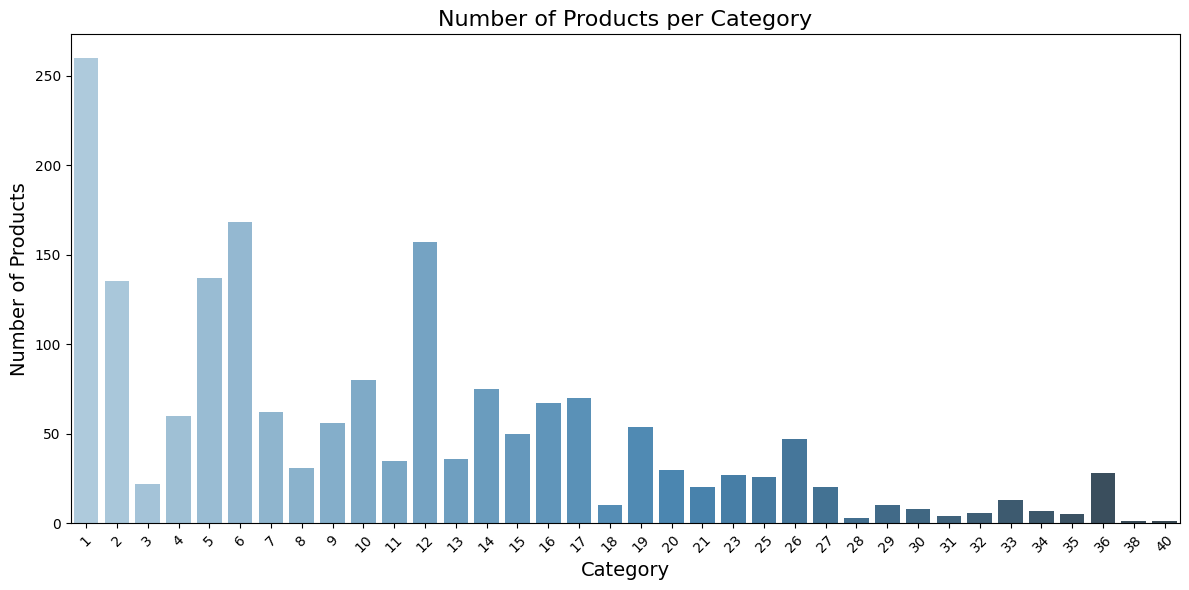

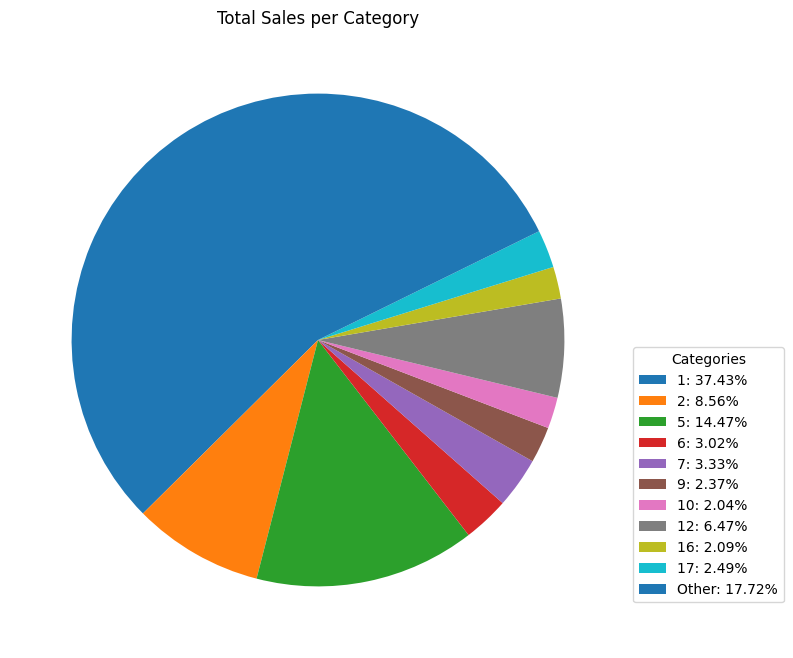

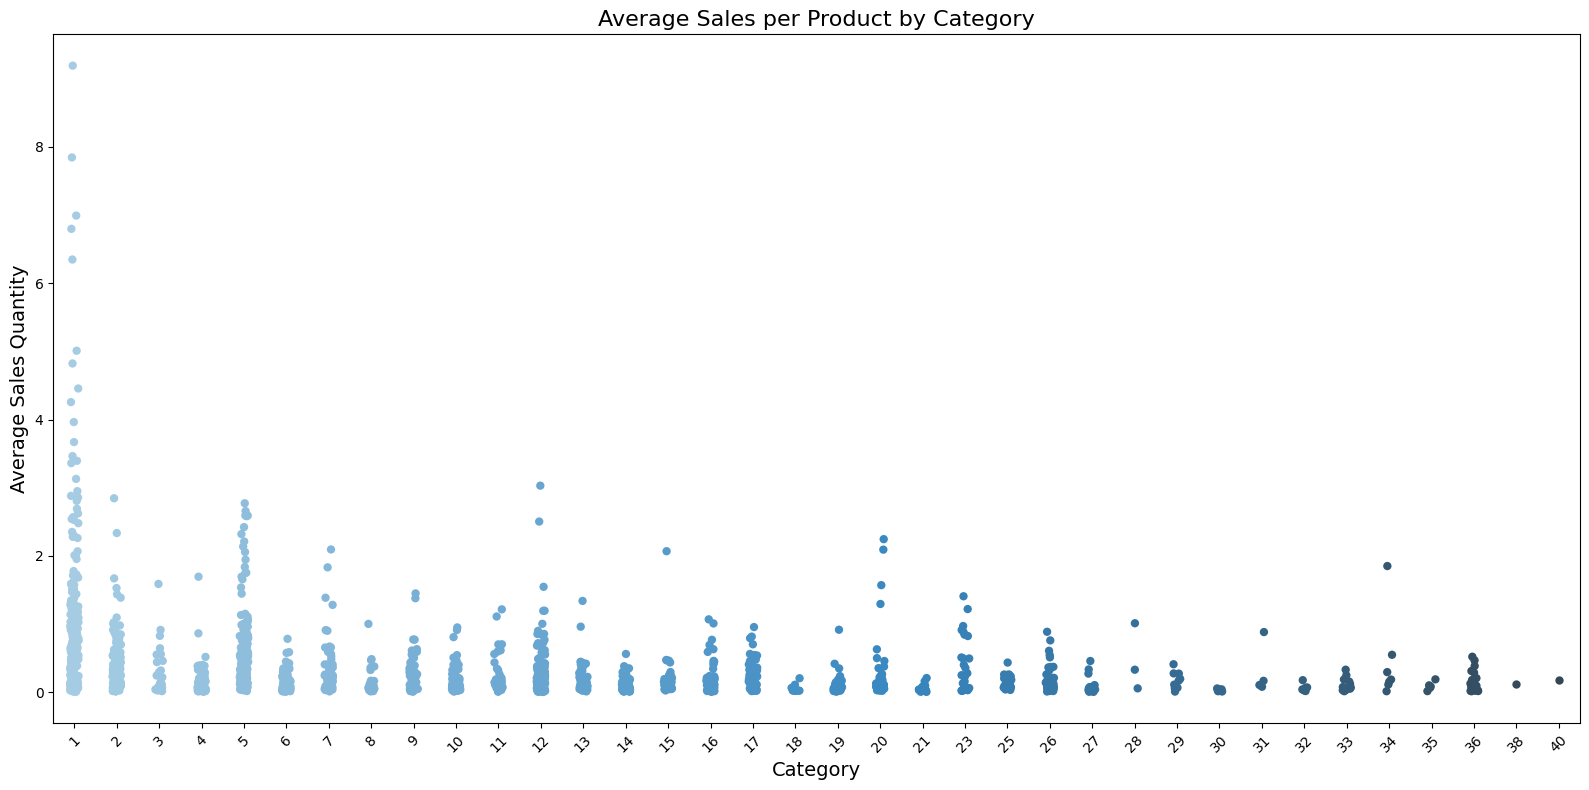

In [308]:
# Group by product and calculate average sales
product_sales = df.groupby('product_id_encoded')['quantity'].mean().sort_values(ascending=False)

# Plot average sales per product
plt.figure(figsize=(14, 6))
sns.barplot(x=product_sales.index, y=product_sales.values, color=colours[18])
plt.title('Average Sales per Product')
plt.xlabel('Product IDs')
plt.ylabel('Average Sales Quantity')
plt.xticks([])  # Hide product IDs for clarity
plt.show()

# Count the number of unique products per category
products_per_category = df.groupby('category_encoded')['product_id_encoded'].nunique().reset_index()
products_per_category.columns = ['category_encoded', 'num_products']

# Plot products per category
plt.figure(figsize=(12, 6))
sns.barplot(x='category_encoded', y='num_products', data=products_per_category, palette=colours[0:36], hue='category_encoded', legend=False)
plt.title('Number of Products per Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Products', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate sales percentages per category
category_sales = df.groupby('category_encoded')['quantity'].sum()
category_sales_percentage = category_sales / category_sales.sum() * 100

# Split categories into major and minor ones based on a threshold
threshold = 2 # Threshold percentage for small categories 
major_categories = category_sales_percentage[category_sales_percentage >= threshold]
minor_categories = category_sales_percentage[category_sales_percentage < threshold]

# Add an "Other" category for all small categories
if len(minor_categories) > 0:
    major_categories['Other'] = minor_categories.sum()

# Create pie chart
plt.figure(figsize=(8, 8))
patches, texts = plt.pie(major_categories, startangle=90)

# Create legend with category code and percentage
legend_labels = [f'{cat}: {round(perc, 2)}%' if cat != 'Other' else f'Other: {round(perc, 2)}%' for cat, perc in zip(major_categories.index, major_categories.values)]
plt.legend(patches, legend_labels, loc="best", bbox_to_anchor=(1, 0.5), title="Categories")
plt.title('Total Sales per Category')
plt.show()

# Calculate the average sales per product within each category
product_avg_sales_per_category = df.groupby(['category_encoded', 'product_id_encoded'])['quantity'].mean().reset_index()

# Create a strip plot
plt.figure(figsize=(16, 8))
sns.stripplot(
    x='category_encoded', 
    y='quantity', 
    data=product_avg_sales_per_category,
    jitter=True,  # Avoid dots stacking on top of each other
    palette=colours[0:36],
    marker='o',
    size=6,
    hue='category_encoded',
    legend=False
)
plt.title('Average Sales per Product by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Average Sales Quantity', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.5. Sales trends over time

This section explores sales patterns across months and weekdays, identifying key temporal fluctuations and behaviors, diving deeper into patterns within products using examples.

* ***Objective:*** To to observe temporal trends (e.g., seasonality or product-specific trends).

* ***Insights:***
    * Monthly, sales are noticeable higher during the warmer months, with clear outliers in December, reflecting expected spikes around the Christmas holidays.

    * Weekly, sales are highest on the weekends, peaking on Saturday, followed by Sunday. Weekday sales patterns also fluctuate, with lower sales seen on Tuesdays and Wednesdays.

    * Comparing the sales over time of 3 products reveals that product sales fluctuate individually with different patterns for each product. 

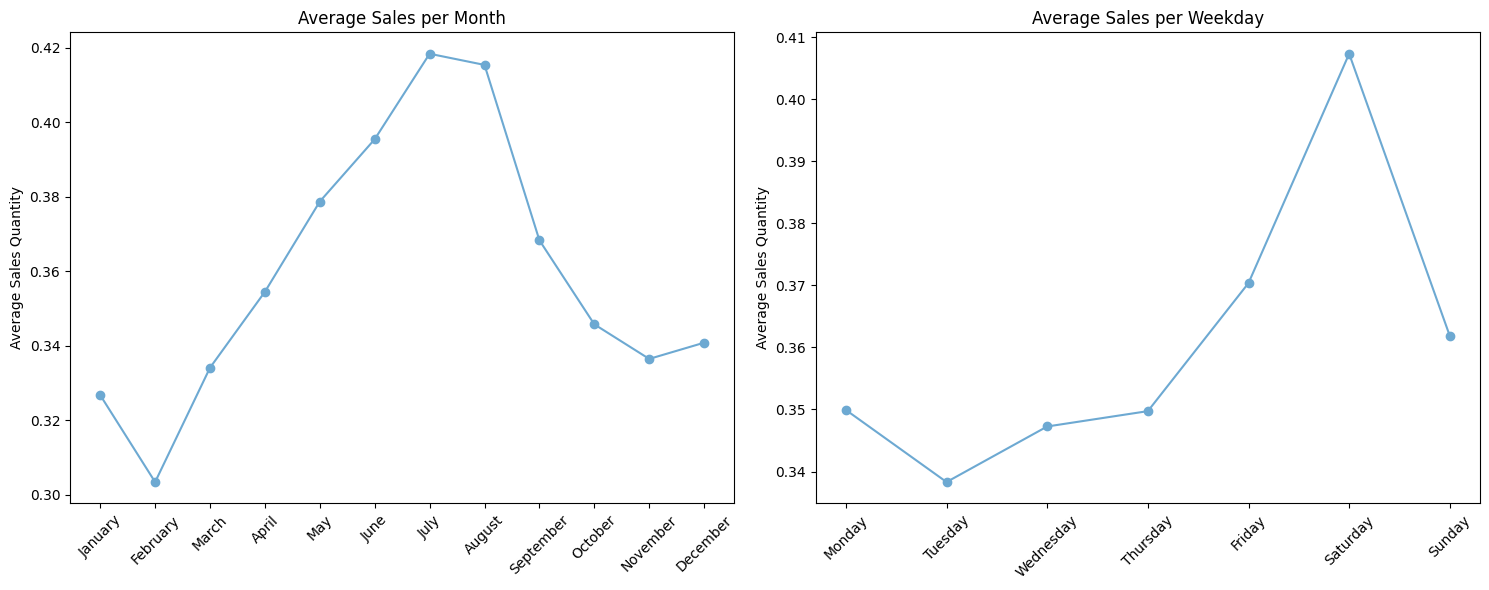

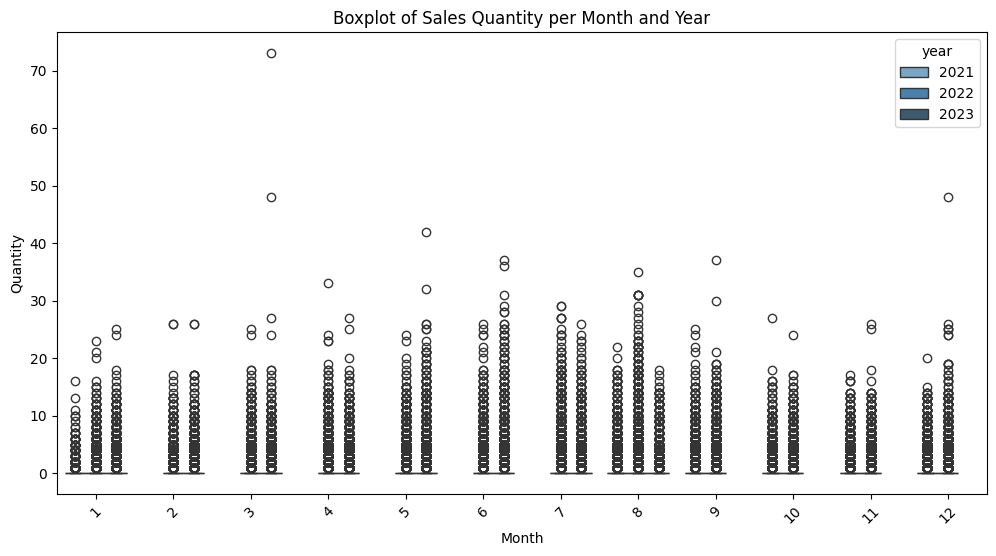

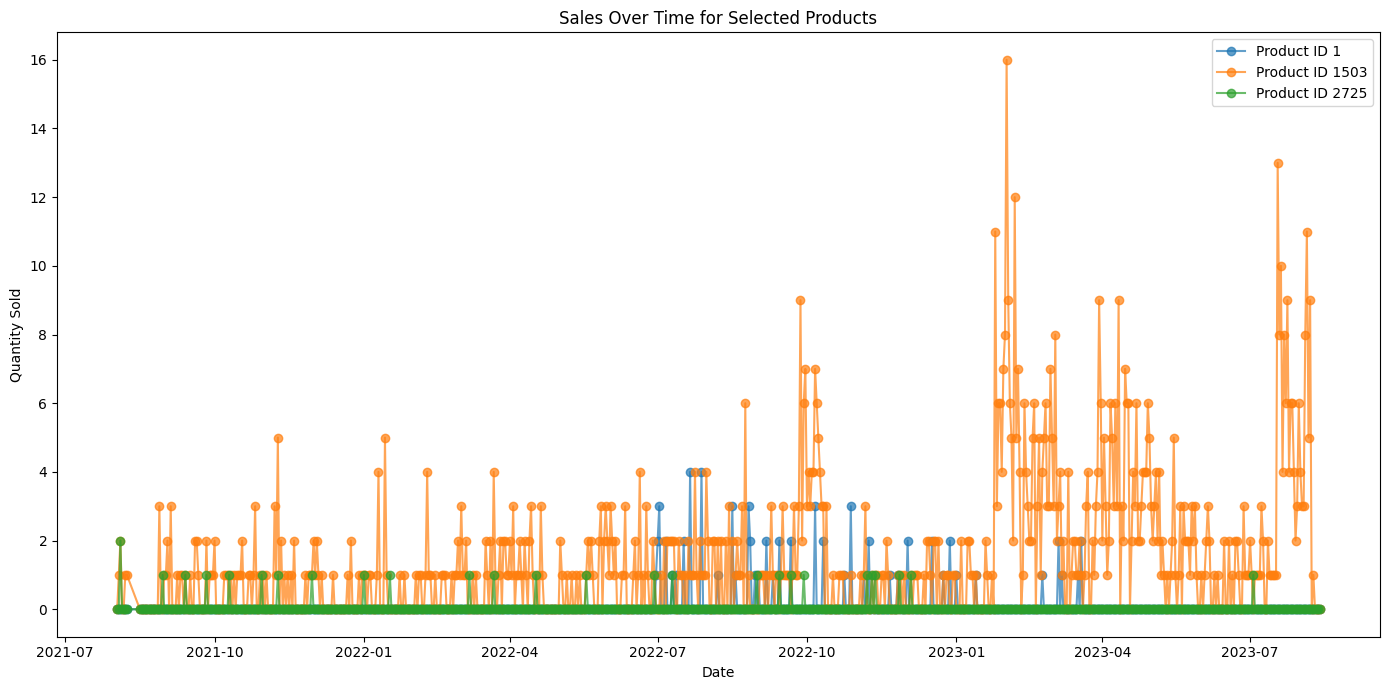

In [297]:
import calendar

# Group sales data by month and weekday 
monthly_sales = df.groupby(df['date'].dt.month)['quantity'].mean()
weekday_sales = df.groupby(df['date'].dt.weekday)['quantity'].mean()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot average sales per month
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', color=colours[10])
axes[0].set_title('Average Sales per Month')
axes[0].set_ylabel('Average Sales Quantity')
axes[0].set_xticks(monthly_sales.index)
axes[0].set_xticklabels([calendar.month_name[i] for i in monthly_sales.index], rotation=45)

# Plot average sales per weekday
axes[1].plot(weekday_sales.index, weekday_sales.values, marker='o', color=colours[10])
axes[1].set_title('Average Sales per Weekday')
axes[1].set_ylabel('Average Sales Quantity')
axes[1].set_xticks(weekday_sales.index)
axes[1].set_xticklabels([calendar.day_name[i] for i in weekday_sales.index], rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Boxplot sales per month and year
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='quantity', hue='year', data=df, palette=[colours[10], colours[20], colours[30],])
plt.title('Boxplot of Sales Quantity per Month and Year')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

# Select 3 sample products based on the most common products
sample_products = df['product_id_encoded'].value_counts().index[:3]

# Plot products' sales over time
plt.figure(figsize=(14, 7))

# Plot sales for each product in a single plot
for product in sample_products:
    product_sales = df[df['product_id_encoded'] == product]
    
    plt.plot(product_sales['date'], product_sales['quantity'], label=f'Product ID {product}', marker='o', alpha=0.7)

# Add title, labels, and legend
plt.title('Sales Over Time for Selected Products')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


### 1.6. Correlation matrix of key features and quantity

This section systematically examines correlations between key features and the target variable `quantity`, as well as themselves by running multiple correlation matrices. 

Important notes:

- While crucial for identifying sales patterns at product level, which is paramount for IM purpose, `product_id_encoded` and `category_encoded` are categorical variables rather than continuous ones, so correlation is not an appropriate tool to assess their relationship with `quantity`. Therefore, they are included in the first full matrix for reference, but their true impact will be assessed using other methods, such as model feature importance.

- Time features, which could offer valuable insights into periodic patterns highly linked to the objective of demand forecast, likely capture non-linear effects that correlation alone won’t reveal fully. Therefore, the focused matrix is used to understand the relationships between time features themselves, rather than against the target `quantity`.

* ***Objective:*** To identify key features for model training with the following goals:

    * Capture seasonal trends

    * Account for product variability, i.e. distinguishing between products and their unique demand patterns

    * Avoid multicollinerality by removing redundant features that are highly correlated features
    
    * Ensure model simplicity for higher generalisation and reduced overfitting

* ***Insights:***

    * The target variable `quantity` shows considerable correlation with rolling average features for 7- to 365-day periods, and to a lesser extent lag features for 1- to 14-day periods.
    
    * Product related features such as `product_id_encoded` and `category_encoded` show no correlations with `quantity`, whereas `in_stock` shows mdoderate correlation, followed by `per_item_value` with a low but existent correlation.

    * The correlation between `quantity` and time-related features (like `month`, `week`, `weekday`) is negligible. 

    * Several lag and rolling average features (e.g., 7-day, 14-day, 30-day), are highly correlated with each other (above 0.9). Similarly, time-related features like `month` and `week` also show high correlation between themselves.

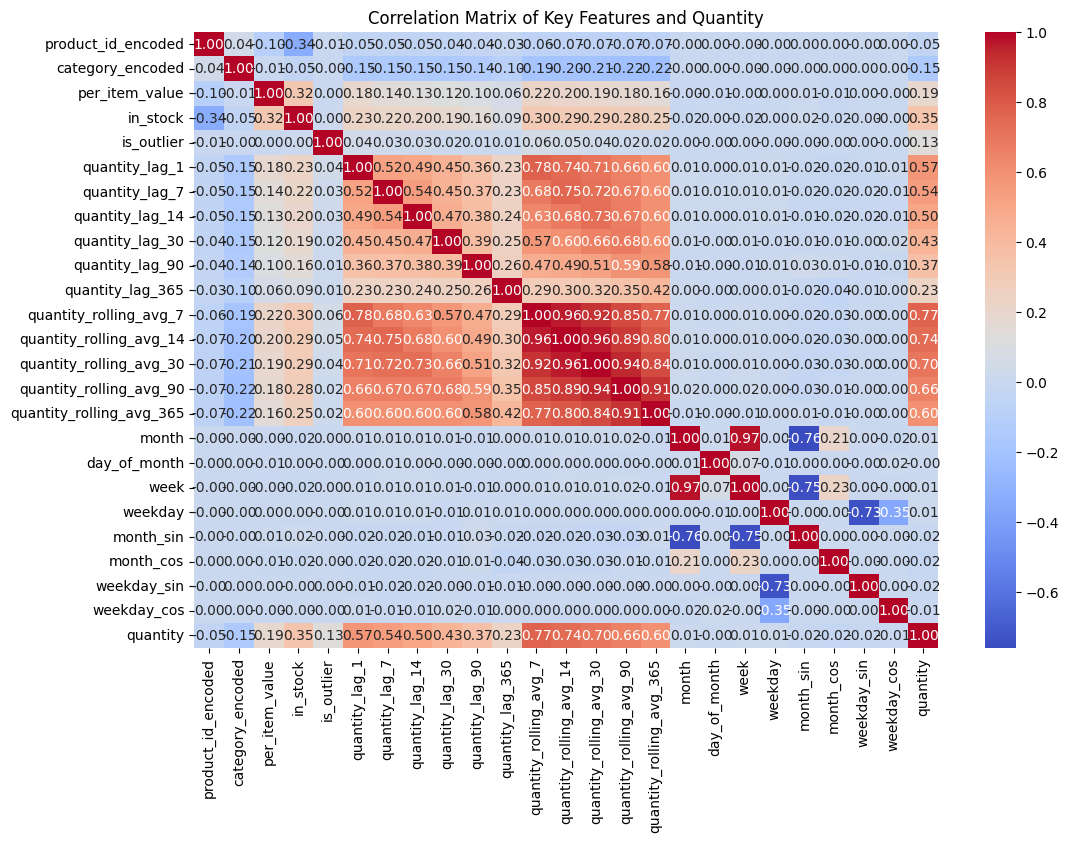

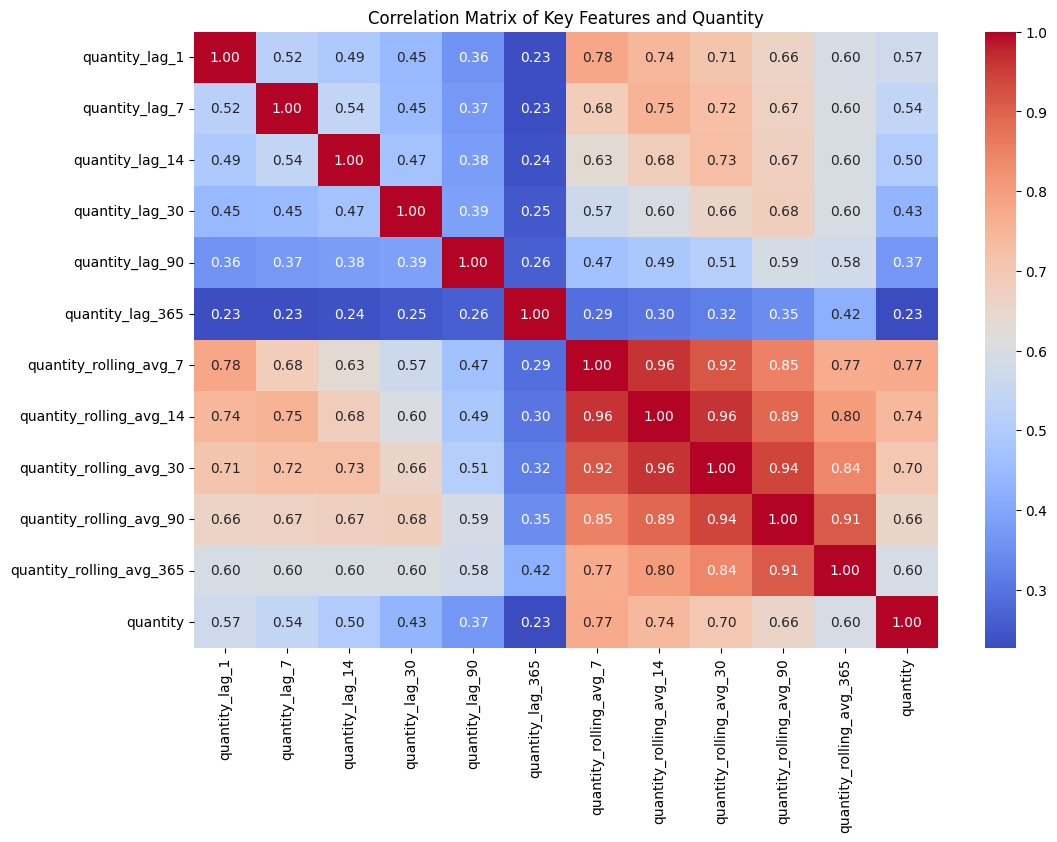

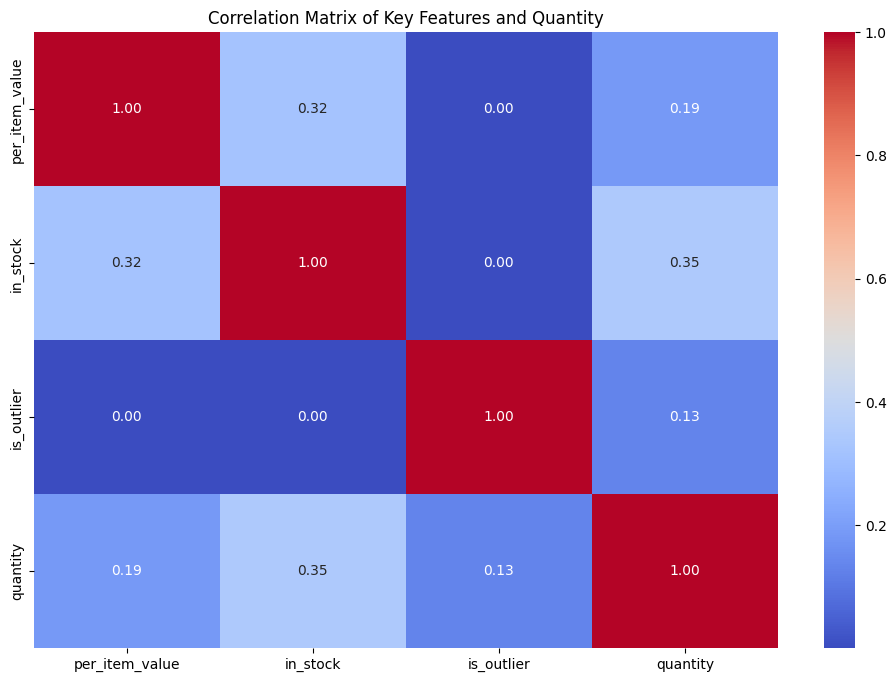

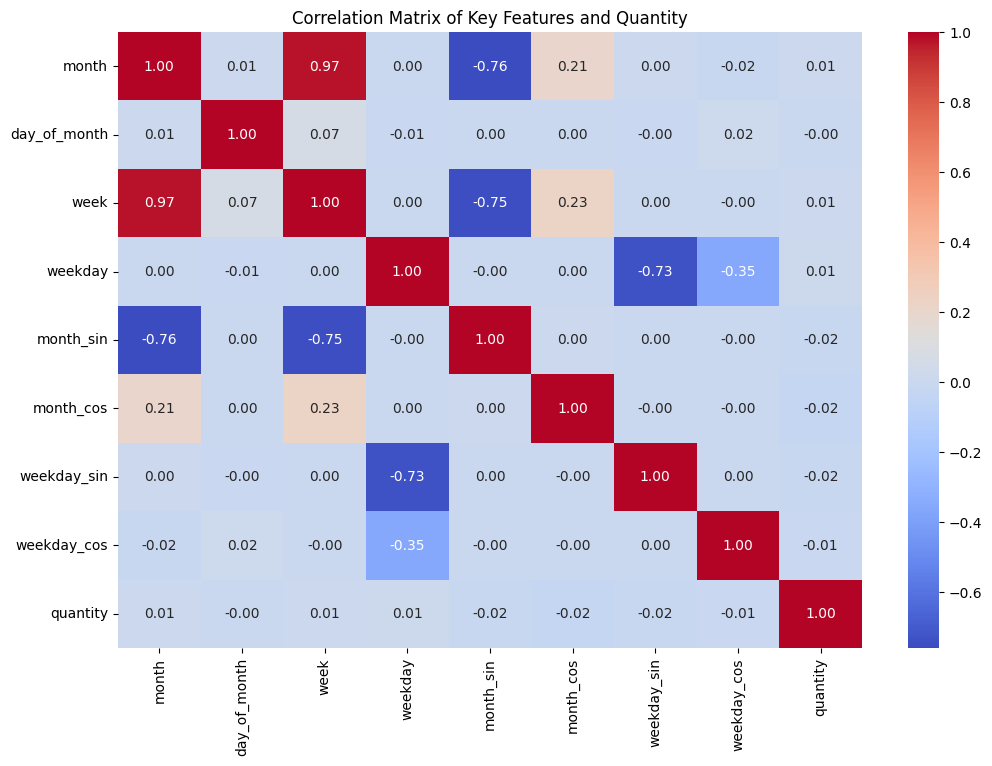

In [298]:
def analyse_correlation(df, features):
    # Generate correlation matrix
    corr_matrix = df[features + ['quantity']].corr()

    # Plot correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Key Features and Quantity')
    plt.show()

# Check correlations between features of interest and the target
all_features_of_interest = [
    'product_id_encoded', 'category_encoded', 'per_item_value', 'in_stock', 'is_outlier',
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365', 
    'month', 'day_of_month', 'week', 'weekday', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
]
analyse_correlation(df, all_features_of_interest)

# Check correlations between time series features and the target
time_series_features = [
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_14', 'quantity_lag_30', 'quantity_lag_90', 'quantity_lag_365',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_14', 'quantity_rolling_avg_30', 'quantity_rolling_avg_90', 'quantity_rolling_avg_365', 
]
analyse_correlation(df, time_series_features)

# Check correlations between time series features and the target
product_info_features = [
    'per_item_value', 'in_stock', 'is_outlier',
]
analyse_correlation(df, product_info_features)

# Check correlations between time features and the target
time_features = [
    'month', 'day_of_month', 'week', 'weekday', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
]
analyse_correlation(df, time_features)

### 1.7. Key takeaways from the EDA

The following findings guide the next steps in building machine learning models:

* **Skewed demand distribution:** The data reveals significant variation in demand across all levels—product, category, and time. This suggests the need for models capable of handling this unbalanced distribution, as well as capturing product-identifying categorical features such as `product_encoded_id` and `category_encoded_id`.

* **Clear seasonality:** Strong seasonal patterns are evident, both monthly and weekly, highlighting the importance of features that capture data related information, particularly the cyclical nature of months and weekdays (`month_sin`, `month_cos`, `weekday_sin`, and `weekday_cos`).

* **Strong predictive features:** Some time series features show strong correlations with future sales, making them required in the feature selection, specifically rolling averages for 7-, 14- and 30-day periods and lags for 1- and 7-day periods.

* **Low predictive power for some features:** Features like `is_outlier` show weak correlations with the target variable and will be excluded to reduce noise. However, features like `per_item_value` and `in_stock` will be retained because, despite their low to mdoerate correlations, they are expected to influence demand patterns in more complex, non-linear ways.

* **Multicollinearity considerations:** High correlations were found between several lag and rolling average features, particularly those with similar time windows. To prevent multicollinearity from negatively affecting model performance, only a subset of these features (e.g., 7-day and 30-day) will be included in the final feature set.

### 1.8. Conslusion

Given the above key takeaways, **XGBoost** and **LightGBM**, both gradient boosting algorithms known for handling complex patterns, imbalanced data, and categorical features, have been selected as powerful model choices for capturing seasonality and product-specific demand variability.


## 2. Feature selection and data splitting

In this section: 

* The **target** variable, `quantity`, which represents the demand for each product, is defined. 

* The relevant **features** are selected based on the EDA key takeaways.

* The dataset is split into training and testing sets chronologically and considering seasonality patterns happen within a year:

    * **Training Set:** First year of data.
    * **Testing Set:** Second year of data.

* `TimeSeriesSplit` is implemented for **coss-validation** as it is a specialised method that maintains temporal order ensuring that the model generalises well and is robust across time periods, which is critical for time-series forecasting.

In [340]:
from sklearn.model_selection import TimeSeriesSplit

# Define target and features
target = 'quantity'

features = [
    'product_id_encoded', 'category_encoded', 
    'quantity_lag_1', 'quantity_lag_7',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30',
    'month_cos', 'month_sin', 'weekday_cos', 'weekday_sin', 
    'in_stock', 'per_item_value',
]

# Split the data based on training until week 31 of 2022
split_date = '2022-08-31'
train_data = df[df['date'] <= split_date]
test_data = df[df['date'] > split_date]

def split_train_test(train_data, test_data, features, target):
    # Separate the features and target variables for training nad testing
    X_train = train_data[features]
    y_train = train_data[target] 
    X_test = test_data[features]
    y_test = test_data[target]

    return X_train, y_train, X_test, y_test

def setup_time_series_split(n_splits=5):
    # TimeSeriesSplit with 5 splits
    return TimeSeriesSplit(n_splits)


X_train, y_train, X_test, y_test = split_train_test(train_data, test_data, features, target)

tscv = setup_time_series_split(5)

## 3. Training models

### 3.1. Randomised search for the best hyperparameters

* **Hyperparameter tuning** is performed using `RandomizedSearchCV` to explore a broad set of hyperparameter combinations efficiently.

* **Mean Absolute Error (MAE)** is selected as the primary evaluation metric since it focuses on minimising the absolute magnitude of prediction errors, making it more interpretable for demand forecasting and reducing the impact of outliers. Therefore, the search process implements `neg_mean_absolute_error` as the scoring metric.

### 3.2. Key hyperparameters

The following hyperparameters are common to both **XGBoost** and **LightGBM** models and play a key role in controlling model complexity and performance:

* `n_estimators`: Controls the number of boosting rounds (trees). Higher values allow the model to capture more patterns but may overfit.
* `learning_rate`: The step size during weight updates. A lower rate makes learning more gradual, while a higher rate increases learning speed but may risk overfitting.
* `max_depth`: Limits the depth of trees. Deeper trees can capture complex relationships, but may lead to overfitting.
* `subsample`: The fraction of training data used for each tree. Reduces overfitting by ensuring trees do not see the entire dataset.
* `colsample_bytree`: Fraction of features sampled for each tree, adding another layer of regularisation to prevent overfitting.
* `reg_alpha` and `reg_lambda`: L1 (alpha) and L2 (lambda) regularisation terms that directly penalise large coefficients in the model to improve generalisation and prevent overfitting.
* `gamma` **(XGBoost)** / `num_leaves` **(LightGBM)**: Both parameters affect the complexity of the trees. `gamma` controls the minimum loss reduction required to make a split in **XGBoost**, while `num_leaves` controls the maximum number of leaves per tree in **LightGBM**, which directly affects tree size and depth.
* `min_child_weight` **(XGBoost)** / `min_child_samples` **(LightGBM)**: Both control the minimum number of samples/weights required to make a split, with larger values preventing small, weak splits, and adding regularisation. `min_child_weight` sets the minimum sum of instance weights (hessian) needed in a child node, while `min_child_samples` sets the minimum number of data points required to form a leaf node.

In [359]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

def random_search_train_model(model, param_grid, X_train, y_train, tscv, scoring_metric='neg_mean_absolute_error', n_iter=50):
    # Set up RandomizedSearchCV with TimeSeriesSplit
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring_metric,  
        cv=tscv,  # Apply TimeSeriesSplit
        verbose=1,
        random_state=42,  # Set random state for reproducibility
        n_jobs=2  # Workers stopped when using all cores
    )

    # Fit the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Get the best hyperparameters from the search
    print(f"Best parameters found for XGBoost: {random_search.best_params_}")

    # Extract the trained model with optimal hyperparameters based on the MAE score
    return random_search.best_estimator_


### 3.3. XGBoost model training

In [358]:
# Initialise the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
}

xgb_best_model = random_search_train_model(xgb_model, xgb_param_grid, X_train, y_train, tscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### 3.4. LightGBM model training

In [323]:
# Initialise the LightGBM model
lgb_model = lgb.LGBMRegressor(verbose=-1)  # Avoid printing progress for clarity

# Define parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'num_leaves': [31, 61], 
    'min_child_samples': [50, 100],
}

lgb_best_model = random_search_train_model(lgb_model, lgb_param_grid, X_train, y_train, tscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found for XGBoost: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


## 4. Model evaluation and comparison

This section provides an evaluation framework for assessing model performance for both **XGBoost** and **LightGBM** and comparing the two. 

### 4.1. Metrics

* **Mean Absolute Error (MAE):** Measures the average magnitude of prediction errors (lower values indicating better accuracy), giving equal weight to all errors. **MAE** is prioritised in this analysis due to its robustness against outliers which should not disproportionately influence model selection, providing a clear and generalisable measure of model accuracy.

* **Root Mean Squared Error (RMSE):** A variation of **Mean Squared Error (MSE)** that gives more weight to larger errors. Lower values of **RMSE** suggest better model performance, particularly for capturing larger prediction errors which can indicate a failure to capture significant shifts in demand.

* **R-squared (R²):** Represents the proportion of variance in the target variable explained by the model, with higher values (closer to 1) suggesting a stronger model fit.


### 4.2. Visualisations

* **Feature Importance** bar charts visualise the key features contributing to each model's predictions, providing interpretability and insight into which features contribute most to the models' decisions.

* A **comparison table and bar charts** summarise the evaluation metrics for both models, enabling a direct comparison of XGBoost and LightGBM performances.

### 4.3. Key takeaways

* ***Metrics***

- **MAE:** Both models have nearly identical values, ~0.25, indicating that on average, both models are off by about 0.25 units per prediction. This is reasonable given the variability in demand at the product level. 

- **RMSE:** These values are also almost identical, ~0.66, meaning that, while both models occasionally make larger errors, those errors aren't extremely frequent or severe.

- **R²:** are also very close, ~0.66, indicating that both models explain around 66% of the variance in the target variable, which is a decent result, suggesting the models capture the main trends and patterns in the data.

* ***Feature importance***

- **XGBoost** places slightly more importance on `product_id_encoded`, suggesting that it might be better at handling product-level specific patterns. However, the difference is not huge, so both models seem competent at capturing product-level demand.

- The 7-day rolling average (`quantity_rolling_avg_7`), seems to be the biggest predictor of demand for both models, followed by the 1-day lag (`quantity_lag_1`) in **XGBoost** and the 30-day rolling average (`quantity_rolling_avg_30`) in **LightGBM**, indicating that **XGBoost** may emphasize short-term fluctuations, while **LightGBM** accounts for medium-term trends.

### 4.4. Conclusions

- Given that the metrics (**MAE, RMSE, R**²) are nearly identical, the feature importance breakdown could be a decisive factor in choosing the model.

- Since precise forecasting at the product level is critical for demand planning and inventory management, **XGBoost**'s emphasis on the `product_id_encoded` feature may better align with business needs.

- **LightGBM**’s more balanced feature importance across rolling averages and lag features suggests it might have a broader perspective on both short- and medium-term trends, which could make it more generalisable across different timeframes.

- Evaluating both models on new data will help confirm which model generalises and performs better.

      Metric  XGBoost  LightGBM
0        MAE   0.2546    0.2549
1       RMSE   0.6588    0.6581
2  R-squared   0.6557    0.6565


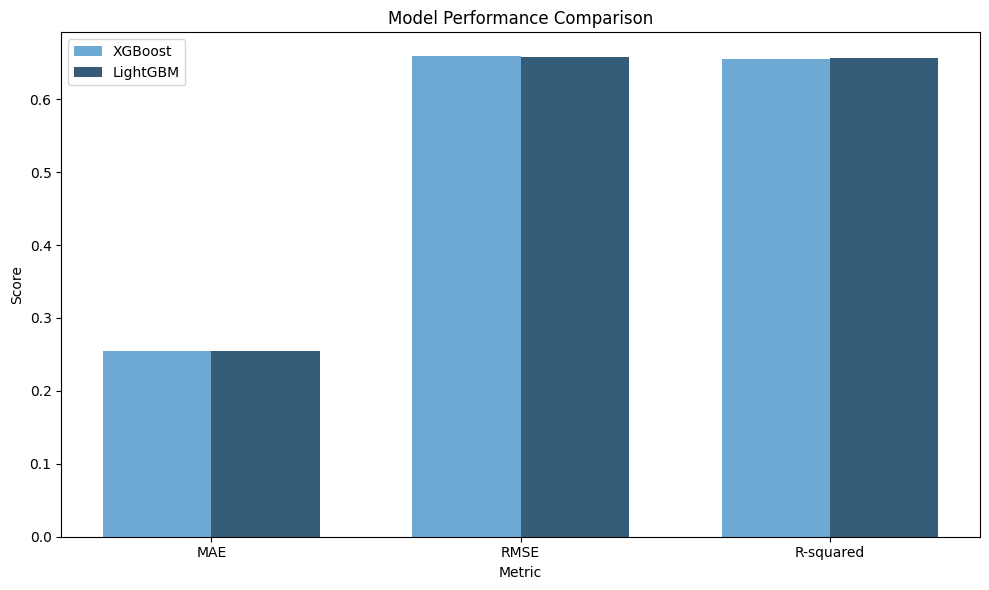

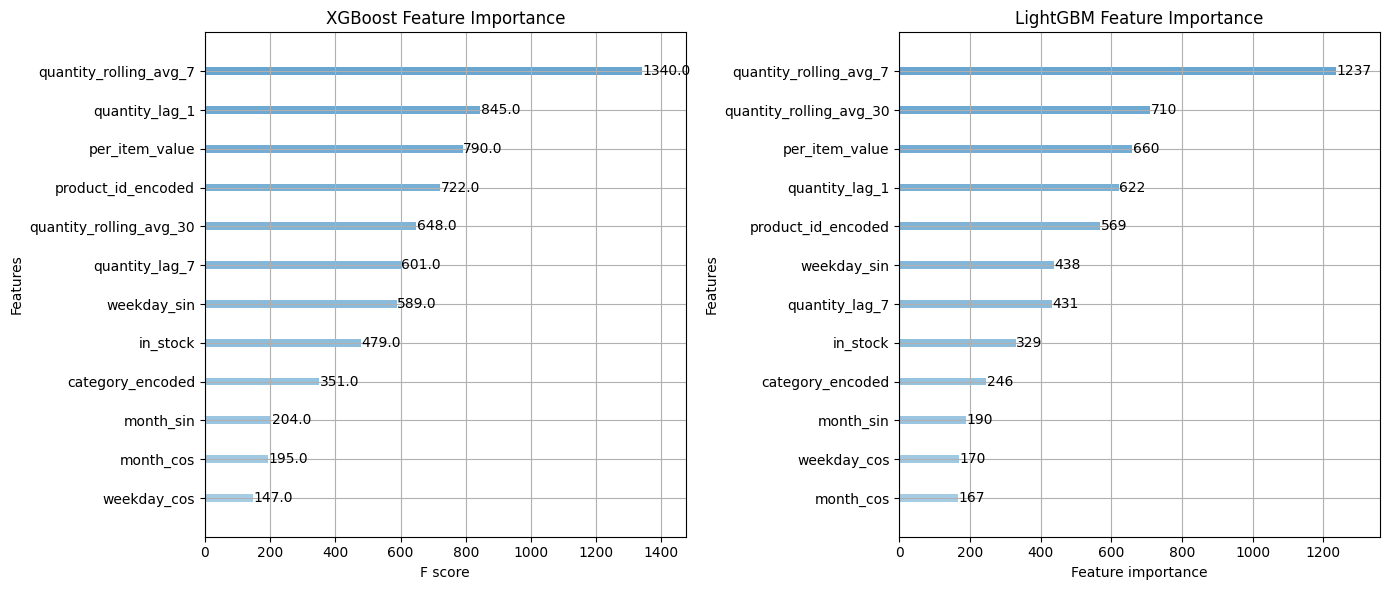

In [345]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def plot_feature_importance(model):
    if isinstance(model, xgb.XGBRegressor):
        xgb.plot_importance(model)
        plt.title('XGBoost Feature Importance')
    elif isinstance(model, lgb.LGBMRegressor):
        lgb.plot_importance(model, max_num_features=10)
        plt.title('LightGBM Feature Importance')
    plt.show()
    
def evaluate_model(model, X_test, y_test, display=True):
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    if display:
        print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")

        plot_feature_importance(model)

    return mae, rmse, r2

def compare_models(model_1, model_2, X_test, y_test):
    model_1_mae, model_1_rmse, model_1_r2 = evaluate_model(model_1, X_test, y_test, False)
    model_2_mae, model_2_rmse, model_2_r2 = evaluate_model(model_2, X_test, y_test, False)

    # Define metrics varuiables
    metrics = ['MAE', 'RMSE', 'R-squared']
    model_1_metrics = [model_1_mae, model_1_rmse, model_1_r2]
    model_2_metrics = [model_2_mae, model_2_rmse, model_2_r2]

    # Print a comparison table
    metrics_data = {
        'Metric': metrics,
        'XGBoost': model_1_metrics,
        'LightGBM': model_2_metrics
    }
    metrics_df = pd.DataFrame(metrics_data)
    print(metrics_df)

    # Create bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(metrics))

    # Bar positions
    ax.bar(index, model_1_metrics, bar_width, label='XGBoost', color=colours[10])
    ax.bar(index + bar_width, model_2_metrics, bar_width, label='LightGBM', color=colours[30])

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics)

    # Add legend
    ax.legend()

    # Show the bar chart
    plt.tight_layout()
    plt.show()

    # Plot feature importance side by side for both models
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot XGBoost feature importance
    xgb.plot_importance(model_1, ax=axes[0], color=colours)
    axes[0].set_title('XGBoost Feature Importance')

    # Plot LightGBM feature importance
    lgb.plot_importance(model_2, ax=axes[1], color=colours)
    axes[1].set_title('LightGBM Feature Importance')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

compare_models(xgb_best_model, lgb_best_model, X_test, y_test)

## 5. Model saving and versioning

In this section, the best-performing models are saved for future use.


In [320]:
import joblib
from datetime import datetime

def save_model(model, filename):
    # Use the current timestamp as the version
    MODEL_VERSION = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save the model
    joblib.dump(model, f'../models/' + filename + '_{MODEL_VERSION}.pkl')
    print(f"XGBoost model (version {MODEL_VERSION}) saved successfully.")

save_model(xgb_best_model, 'xgboost_demand_forecast_model')
save_model(lgb_best_model, 'lightgbm_demand_forecast_model')

XGBoost model (version 20240928_134943) saved successfully.
LightGBM model (version 20240928_134943) saved successfully.


## 6. Fruther model fine-tuning

In this section a systematic approach is carried out to run a few experiments with the goal to adjust the models to achieve better metrics. 

### 6.1. Reducing noise

The following experiment explores the impact of reduced noise by removing some features that were seen to not contribute greatly to models' decisions in the previous evaluation. Features removed: `month_cos`, `weekday_cos`, and `category_encoded`.

Results showed marginal differences.

      Metric  XGBoost  LightGBM
0        MAE   0.2548    0.2556
1       RMSE   0.6596    0.6595
2  R-squared   0.6549    0.6550


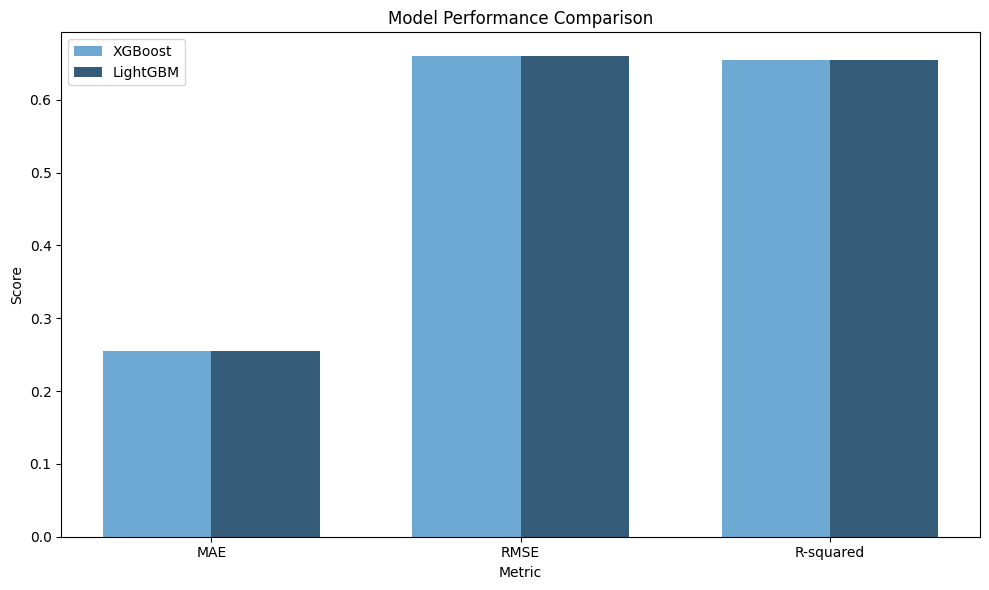

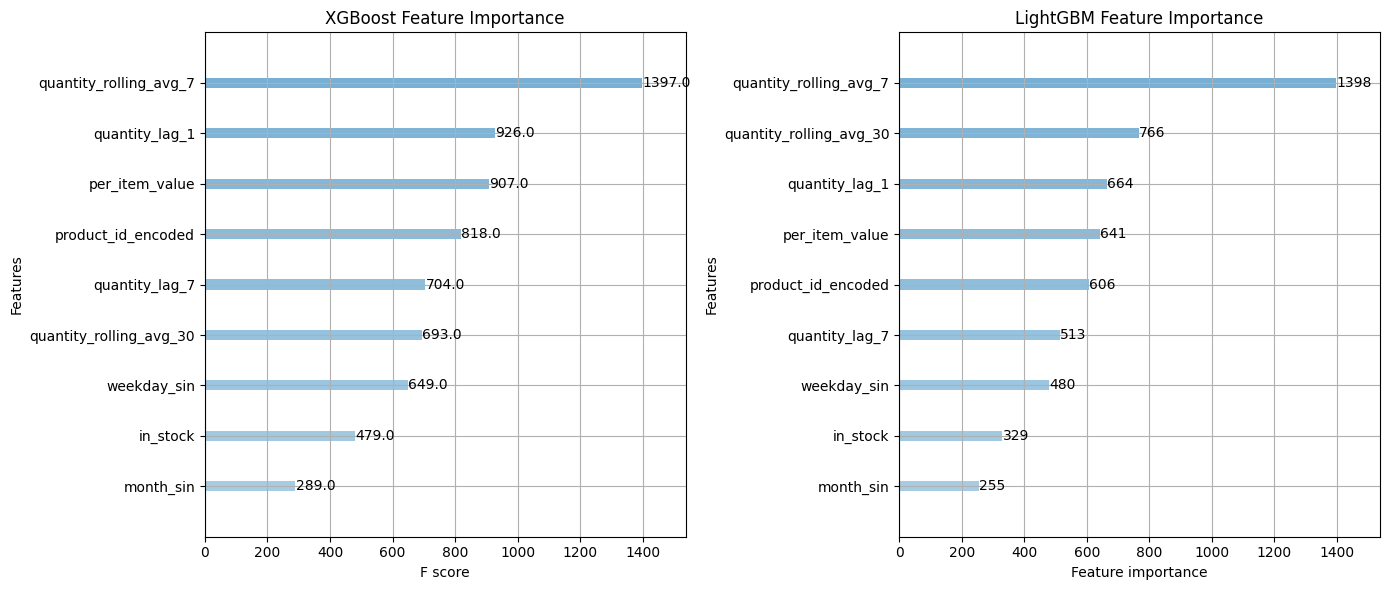

In [347]:
def train_and_compare_models(X_train, y_train, X_test, y_test):
    # Train XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,        
        learning_rate=0.05,   
        max_depth=7,          
        subsample=0.8,
        colsample_bytree=1.0,
        reg_alpha=0.5,
        reg_lambda=0.1,
        gamma=0.5,
        min_child_weight=7
    )
    xgb_model.fit(X_train, y_train)

    # Train LightGBM model
    lgb_model = lgb.LGBMRegressor(
        n_estimators=200,
        subsample=0.8, 
        num_leaves=31,
        min_child_samples=100,
        learning_rate=0.05,
        colsample_bytree=1.0,
        max_depth=10,
        reg_lambda=0.5,
        reg_alpha=0.5, 
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)

    # Compare the models
    compare_models(xgb_model, lgb_model, X_test, y_test)

    return xgb_model, lgb_model

# Define new features
features_exp1 = [
    'product_id_encoded', 
    'quantity_lag_1', 'quantity_lag_7',
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30',
    'month_sin', 'weekday_sin', 
    'in_stock', 'per_item_value',
]

X_train_exp1, y_train_exp1, X_test_exp1, y_test_exp1 = split_train_test(train_data, test_data, features_exp1, target)

xgb_model_exp1, lgb_model_exp1 = train_and_compare_models(X_train_exp1, y_train_exp1, X_test_exp1, y_test_exp1)


### 6.2. Reducing multicollinearity

The following experiment explores the impact of dropping features based on their correlation. The feature removed is `quantity_rolling_avg_30` due to its correlation with `quantity_rolling_avg_7`.

In this case as well, the results showed marginal differences.

      Metric  XGBoost  LightGBM
0        MAE   0.2546    0.2555
1       RMSE   0.6600    0.6592
2  R-squared   0.6546    0.6553


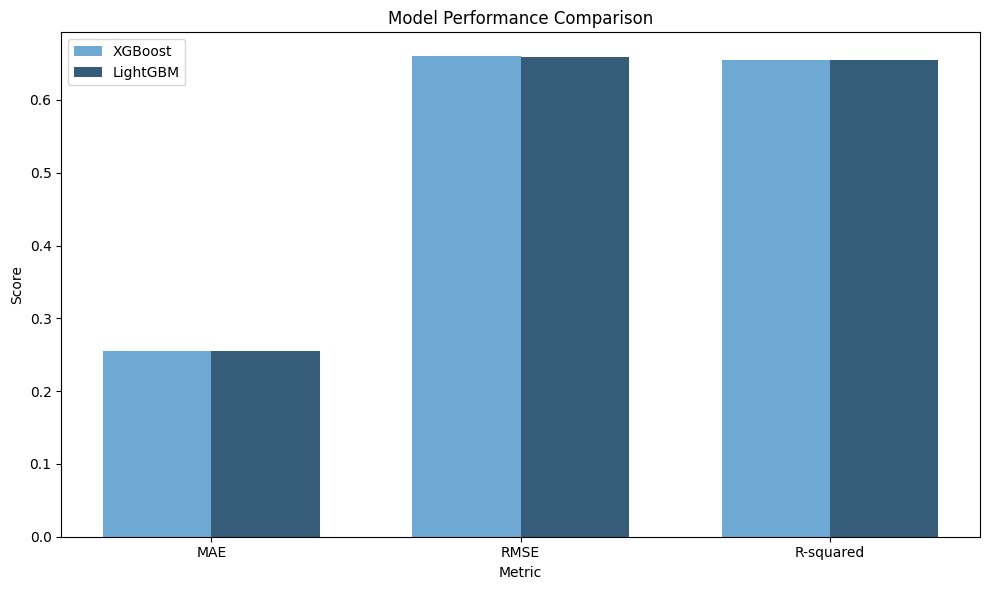

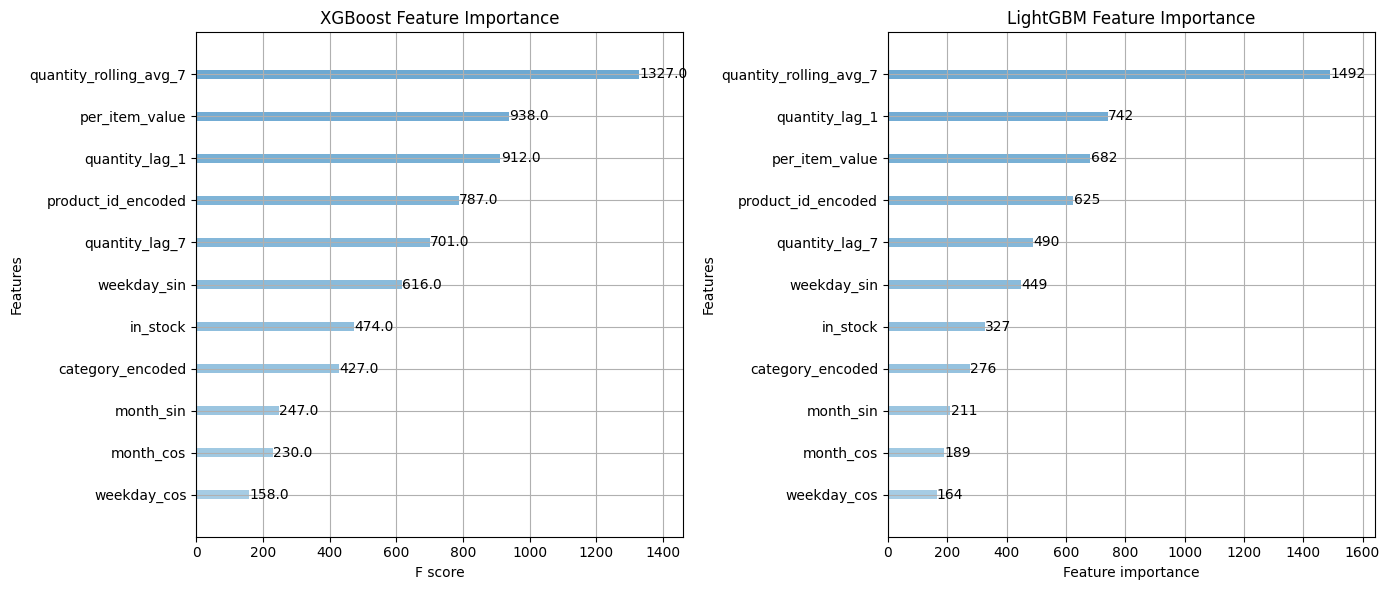

In [348]:
# Define new features
features_exp2 = [
    'product_id_encoded', 'category_encoded', 
    'quantity_lag_1', 'quantity_lag_7',
    'quantity_rolling_avg_7', 
    'month_cos', 'month_sin', 'weekday_cos', 'weekday_sin', 
    'in_stock', 'per_item_value',
]

X_train_exp2, y_train_exp2, X_test_exp2, y_test_exp2 = split_train_test(train_data, test_data, features_exp2, target)

xgb_model_exp2, lgb_model_exp2 = train_and_compare_models(X_train_exp2, y_train_exp2, X_test_exp2, y_test_exp2)


### 6.3. Experimenting with time series features

In this experiment, lags and rolling averages are experimented with by manually running multiple combinations to test ideas like higher day periods having an impact in performance.

Again, the results showed marginal differences.

      Metric  XGBoost  LightGBM
0        MAE   0.2548    0.2553
1       RMSE   0.6589    0.6585
2  R-squared   0.6556    0.6561


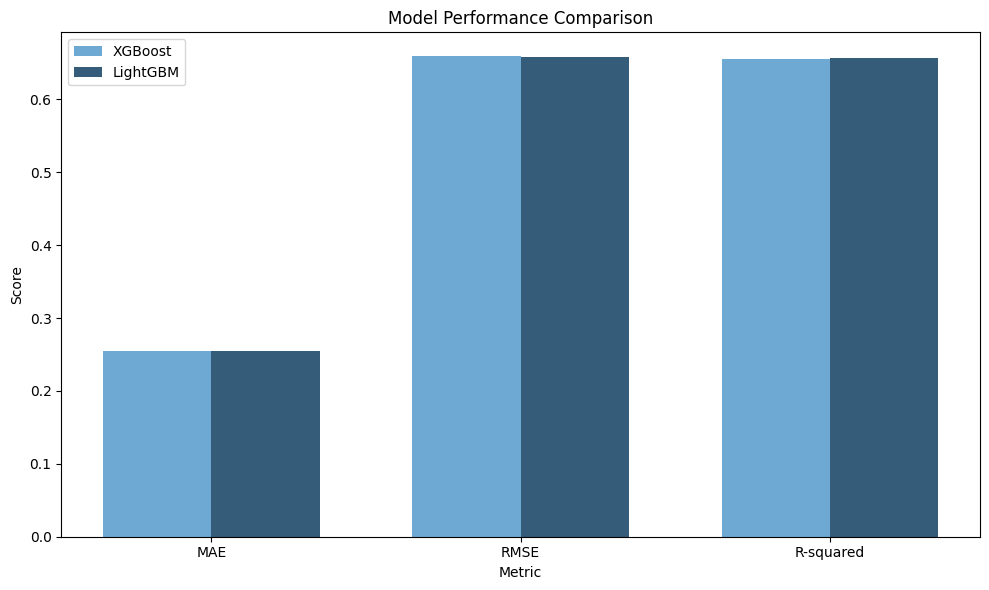

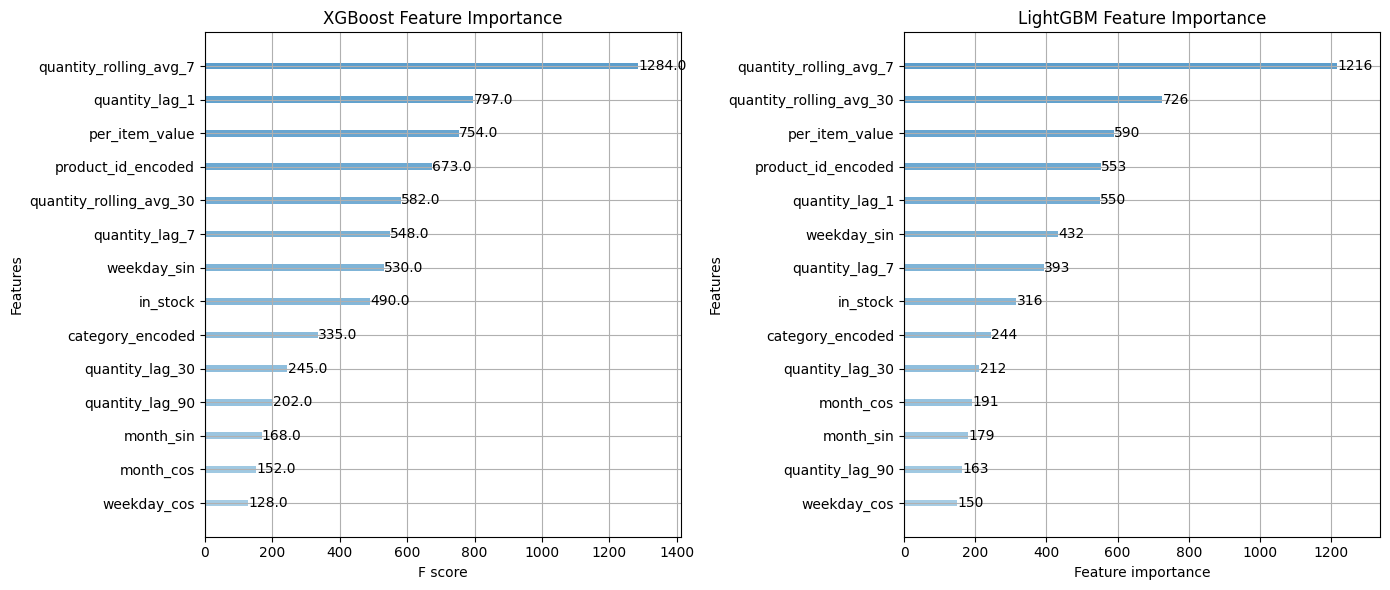

In [356]:
features_exp3 = [
    'product_id_encoded', 'category_encoded', 
    'quantity_lag_1', 'quantity_lag_7', 'quantity_lag_90', 'quantity_lag_30', 
    'quantity_rolling_avg_7', 'quantity_rolling_avg_30',
    'month_cos', 'month_sin', 'weekday_cos', 'weekday_sin', 
    'in_stock', 'per_item_value',
]

X_train_exp3, y_train_exp3, X_test_exp3, y_test_exp3 = split_train_test(train_data, test_data, features_exp3, target)

xgb_model_exp3, lgb_model_exp3 = train_and_compare_models(X_train_exp3, y_train_exp3, X_test_exp3, y_test_exp3)

### 6.4. Experimenting with time series features

This experiment applies a higher numebr of splits to the time series split for broader cross-validation.

For XGBoost, the results returned the same best parameters as the original search with 5 splits. LightGBM returned new parameters and the performance metrics showed minimal impreovements - on the third decimal place - but these were not significant in practical terms, especially for the overall performance of the model. 

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found for XGBoost: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0}
MAE: 0.2546223702743435, RMSE: 0.6588206434059488, R²: 0.6557371616363525


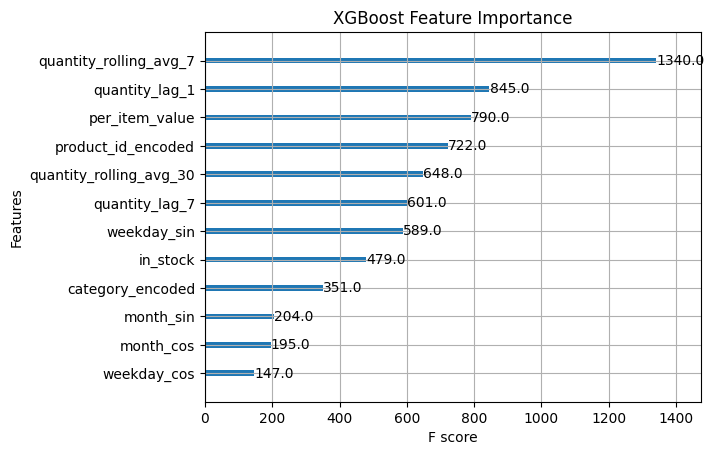

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/Users/mireiataboada/personal-repos/project-module-2024-apr-mireiatz/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found for XGBoost: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 61, 'n_estimators': 100, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
MAE: 0.2548261438960787, RMSE: 0.657955444678397, R²: 0.6566408174852361


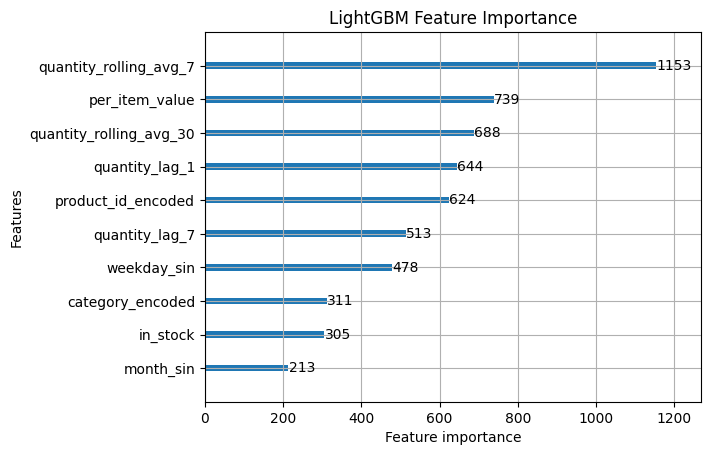

(0.2548261438960787, 0.657955444678397, 0.6566408174852361)

In [362]:
tscv_exp4 = TimeSeriesSplit(n_splits=10)

# Initialise the XGBoost model
xgb_model_exp4 = xgb.XGBRegressor()

xgb_best_model_exp4 = random_search_train_model(xgb_model_exp4, xgb_param_grid, X_train, y_train, tscv_exp4)

evaluate_model(xgb_best_model_exp4, X_test, y_test)

# Initialise the LightGBM model
lgb_model_exp4 = lgb.LGBMRegressor(verbose=-1)

lgb_best_model_exp4 = random_search_train_model(lgb_model_exp4, lgb_param_grid, X_train, y_train, tscv_exp4)

evaluate_model(lgb_best_model_exp4, X_test, y_test)

### 6.5. Key takeaways and conclusion

No experiments resulted in a significant improvement of the model performance or any insights into opportunities to build better performing models. Therefore, no reason was found to save any of the models built during experimentation.

I conclusion, this notebook concludes with two robust models saved for demand forecast prediction within this project.